In [1]:
#Data path
restaurant_data_path = 'data/restaurants.json'
#restaurant_reviews_data_path = 'output/restaurant_reviews.json'
restaurant_reviews_latest_data_path = 'data/restaurant_reviews_latest.json'


In [2]:
# load restaurant data into a data frame
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

def load_restaurants_into_df(filename,keys):
    list_of_restaurants = []
    with open(restaurant_data_path,'r',encoding='utf-8') as f:
        for line in f:
            row = json.loads(line)
            row_dict = {}
            for key in keys:
                row_dict[key] = row[key]
            
            list_of_restaurants.append(row_dict)
    
    return pd.DataFrame(list_of_restaurants)

restaurants_df = load_restaurants_into_df(restaurant_data_path,['business_id','stars','state'])

    

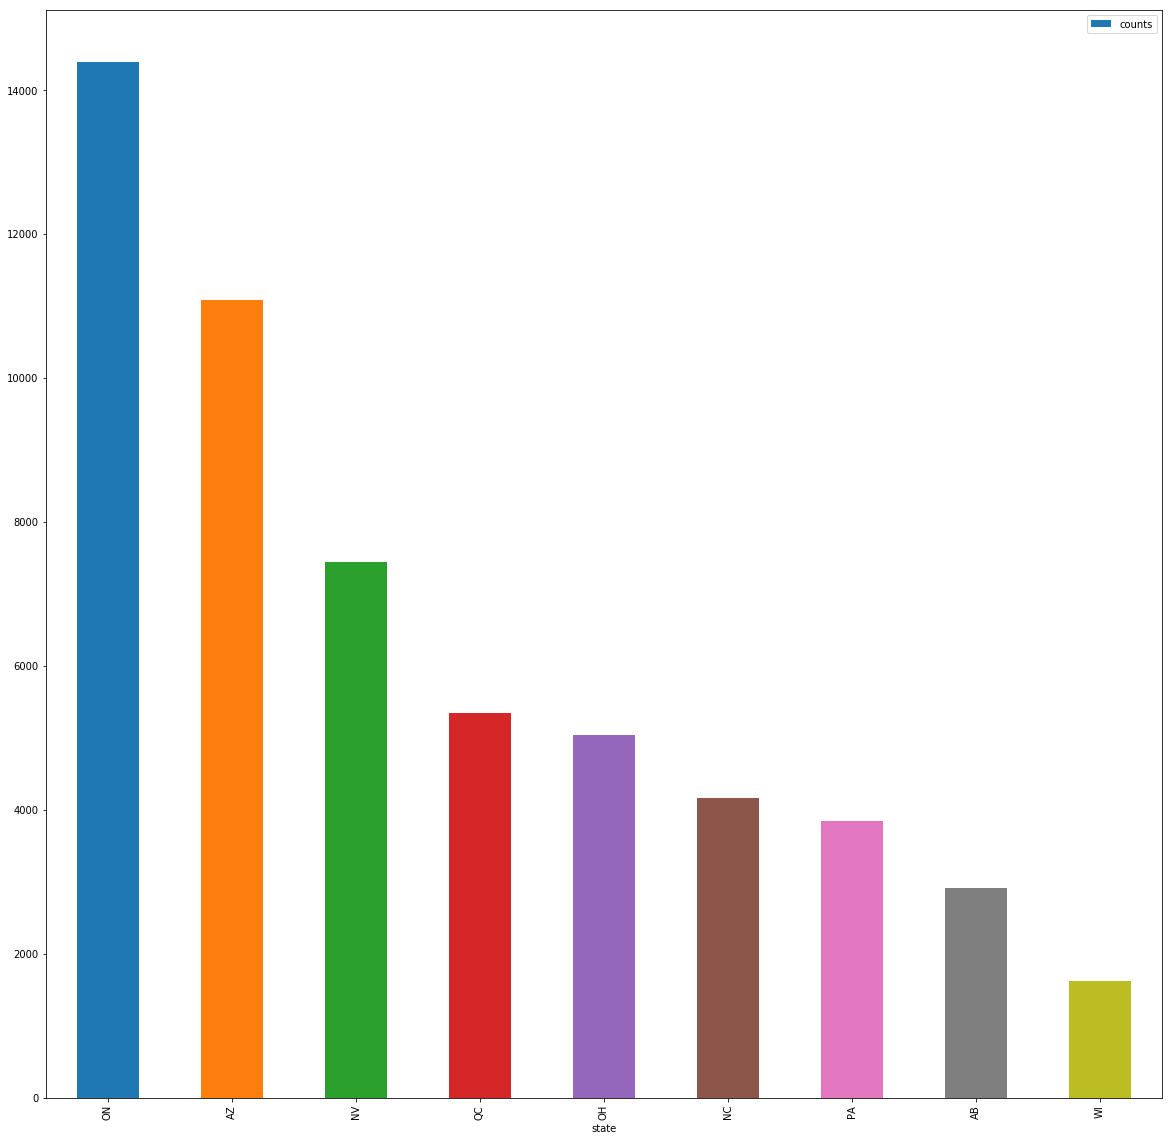

In [3]:
grouped = restaurants_df.groupby('state').size().reset_index(name='counts')
grouped_by_count_gt_1000 = grouped[grouped.counts > 1000].sort_values(by='counts',ascending = False)
grouped_by_count_gt_1000.plot.bar(x='state', y='counts',figsize=(20,20),fontsize=(10))


In [4]:
# Based on above grave we will pick one of states with higher restaurants in United states - say NV

In [14]:
state_code = 'AZ'
state_restaurants = restaurants_df[restaurants_df.state == state_code]
restaurant_ids = set(state_restaurants.business_id.values)

# def load_user_reviews_by_business(filename,restaurant_ids):
#     reviews = []
#     with open(filename,'r',encoding='utf-8') as f:
#         for line in f:
#             row = json.loads(line)
#             business_id = row['business_id']
#             if business_id in restaurant_ids:
#                 reviews.append(row)
    
#     return pd.DataFrame(reviews)

import nltk
ps = nltk.PorterStemmer()
nltk.download('punkt')
def get_stemmed_text(text):
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [ps.stem(x) for x in tokens]
    return ' '.join(stemmed_tokens)

def load_user_reviews_by_business(filename,restaurant_ids):
    reviews = []
    with open(filename,'r',encoding='utf-8') as f:
        i = 0
        for line in f:
            row = json.loads(line)
            business_id = row['business_id']
            if business_id in restaurant_ids:
#                 row['text'] = get_stemmed_text(row['text'])
                reviews.append(row)
                if i % 10000 == 0:
                    print(i)
                i+=1
    
    return pd.DataFrame(reviews)


state_restaurant_reviews_df = load_user_reviews_by_business(restaurant_reviews_latest_data_path,restaurant_ids)
state_restaurant_reviews_df.shape


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000


(460836, 5)

In [15]:
state_restaurant_reviews_df['review_length'] = state_restaurant_reviews_df.text.map(len)
star1_df = state_restaurant_reviews_df[state_restaurant_reviews_df.stars == 1]
star1_df.shape

(69265, 6)

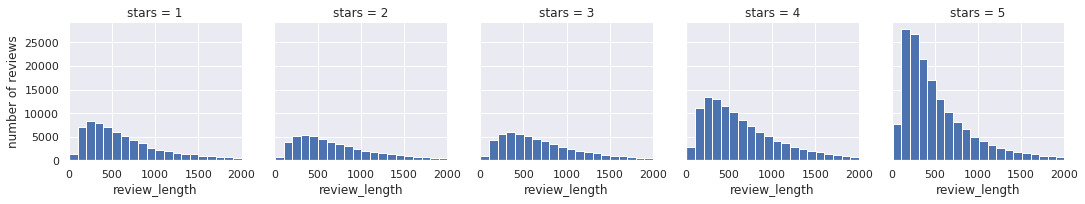

In [16]:
import seaborn as sns
sns.set()
ax = sns.FacetGrid(data=state_restaurant_reviews_df, col='stars', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='number of reviews');

In [17]:
pos_reviews = state_restaurant_reviews_df.text[state_restaurant_reviews_df.stars>3].values
neg_reviews = state_restaurant_reviews_df.text[state_restaurant_reviews_df.stars<3].values
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))


Postive Reviews:  281,634
Negative Reviews:  121,504


In [18]:
%%time
# neg_reviews = neg_reviews[:300]
# pos_reviews = pos_reviews[:300]
from sklearn.feature_extraction.text import TfidfVectorizer
tf_pos = TfidfVectorizer(stop_words='english', min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tf_neg = TfidfVectorizer(stop_words='english', min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

neg_vectors = tf_neg.fit_transform(neg_reviews)
pos_vectors = tf_pos.fit_transform(pos_reviews)

CPU times: user 30.1 s, sys: 654 ms, total: 30.8 s
Wall time: 30.8 s


In [19]:
from time import time
t0 = time()
timeList = []



In [20]:
%%time

from sklearn.decomposition import NMF


def train_nmf(num_topics,pos_vectors,neg_vectors):
    lda_pos = NMF(n_components=num_topics)
    W_pos = lda_pos.fit_transform(pos_vectors)
    H_pos = lda_pos.components_
    
    
    lda_neg = NMF(n_components=num_topics)
    W_neg = lda_neg.fit_transform(neg_vectors)
    H_neg = lda_neg.components_
    
    return lda_pos,lda_neg,W_pos,H_pos,W_neg,H_neg


import numpy as np
def display_topics(model, feature_names, num_topics, no_top_words,no_top_documents,W,documents):
    topic_list = []
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            topic_ = str("{:11}".format("Topic %d:" %(topic_idx)))
            topic_words = str(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))
            topic_list.append(topic_+topic_words)
            
    return topic_list

def write_list_to_file(filename,list_of_strings):
    with open(filename,'w',encoding='utf-8') as f:
        for string in list_of_strings:
            f.write(string + '\n')

def run_full_flow(num_topics,pos_vectors,neg_vectors):
    t0 = time()
    lda_pos,lda_neg,W_pos,H_pos,W_neg,H_neg = train_nmf(num_topics,pos_vectors,neg_vectors)
    time_taken = time() - t0
    seconds = str("%0.3fs." % (time_taken))
    timeList.append("Topics: " + str(num_topics) + " " + "Time: " + seconds)
    no_top_words = 9
    positive_topic_list = display_topics(lda_pos, tf_pos.get_feature_names(), num_topics, no_top_words,2,W_pos,pos_reviews)
    negative_topic_list = display_topics(lda_neg, tf_neg.get_feature_names(), num_topics, no_top_words,2,W_neg,neg_reviews)
    
    pos_topics_file_name = str(num_topics) + "_" + "positive_topics.txt" 
    neg_topics_file_name = str(num_topics) + "_" + "negative_topics.txt"
    
    write_list_to_file('output_az_nmf/'+ pos_topics_file_name,positive_topic_list)
    write_list_to_file('output_az_nmf/'+ neg_topics_file_name,negative_topic_list)
    
    
    state_restaurant_pos_reviews_df = state_restaurant_reviews_df[['business_id', 'stars', 'text', 'review_length']][state_restaurant_reviews_df.stars>3].reset_index()
    state_restaurant_neg_reviews_df = state_restaurant_reviews_df[['business_id', 'stars', 'text', 'review_length']][state_restaurant_reviews_df.stars<3].reset_index()
    state_restaurant_pos_reviews_df.drop(labels='index', axis=1, inplace=True)
    state_restaurant_neg_reviews_df.drop(labels='index', axis=1, inplace=True)
    
    from sklearn.preprocessing import normalize
    
    state_restaurant_pos_reviews_cm = pd.concat([state_restaurant_pos_reviews_df, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
    state_restaurant_neg_reviews_cm = pd.concat([state_restaurant_neg_reviews_df, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)


    state_restaurant_pos_reviews_cm.drop(labels='text', axis=1, inplace=True)
    state_restaurant_pos_reviews_cm.drop(labels='review_length', axis=1, inplace=True)
    state_restaurant_neg_reviews_cm.drop(labels='text', axis=1, inplace=True)
    state_restaurant_neg_reviews_cm.drop(labels='review_length', axis=1, inplace=True)
    
    agg_topic_vector_columns = {x:'mean' for x in range(num_topics)}
    agg_topic_vector_columns['stars'] = 'mean'

    df_pos_bsns = state_restaurant_pos_reviews_cm.groupby('business_id').agg(agg_topic_vector_columns).reset_index()
    df_neg_bsns = state_restaurant_neg_reviews_cm.groupby('business_id').agg(agg_topic_vector_columns).reset_index()
    
    merged_business_topic_df = pd.merge(df_pos_bsns, df_neg_bsns, on='business_id', how='outer',suffixes=('_pos', '_neg'))
    
    
    merged_business_topic_df = merged_business_topic_df.fillna(0)
    merged_business_topic_df = pd.merge(merged_business_topic_df,restaurants_df,on='business_id',how='inner')
    
    
    pos_feature_names = [str(x)+'_pos' for x in range(num_topics)]
    neg_feature_names = [str(x)+'_neg' for x in range(num_topics)]
    feature_cols = pos_feature_names + neg_feature_names
    X = merged_business_topic_df.loc[:, feature_cols]
    X.shape
    Y = merged_business_topic_df.loc[:, ['stars']].values.ravel()
    Y.shape
    
    from sklearn.linear_model import LinearRegression

    from sklearn.metrics import mean_squared_error
    from scipy.stats import pearsonr
    from math import sqrt
    
    from sklearn.svm import SVR

    def run_supervised(X_Train,Y_Train,X_Test,Y_Test):
        model = SVR(gamma='scale', C=1.0, epsilon=0.2)
        model.fit(X_Train,Y_Train)
        Y_Pred = model.predict(X_Test)
        MSE = mean_squared_error(Y_Test,Y_Pred)
        print(MSE)
        Pearsons_coefficient,p_value = pearsonr(Y_Test,Y_Pred)
        mse = "MSE," + str(MSE)
        pearsons = "Pearsons," + str(Pearsons_coefficient)
        rmse = "RMSE," + str(sqrt(MSE))
        return [mse,pearsons,rmse]
        
        
    split = int(0.85 * Y.shape[0])
    X_Train = X[:split]
    Y_Train = Y[:split]

    X_Test = X[split:]
    Y_Test = Y[split:]

    evaluation_metrics = run_supervised(X_Train,Y_Train,X_Test,Y_Test)
    
    metrics_file_name = str(num_topics) +  '_evaluation_metrics.txt'
    write_list_to_file('output_az_nmf/' + metrics_file_name,evaluation_metrics)

# # change num_topics  start with 6 then go to 7 8 9 10 and 15 , you can see that 9 gives the best MSE ,RMSE and pearson
# num_topics = 6
# max_iter = 1


# nmf_pos = LatentDirichletAllocation(n_components=num_topics, max_iter=max_iter,
#                                 learning_method='online',
#                                 learning_offset=50.,
#                                 random_state=0)

# W_pos = nmf_pos.fit_transform(pos_vectors)
# H_pos = nmf_pos.components_

# nmf_neg = LatentDirichletAllocation(n_components=num_topics, max_iter=max_iter,
#                                 learning_method='online',
#                                 learning_offset=50.,
#                                 random_state=0)
# W_neg = nmf_neg.fit_transform(neg_vectors)
# H_neg = nmf_neg.components_

CPU times: user 34 µs, sys: 0 ns, total: 34 µs
Wall time: 39.1 µs


In [21]:
topics = [5,8,10,15,23]
no_of_iterations=[1,5,10]
for topic in range(5,24):
    run_full_flow(topic,pos_vectors,neg_vectors)

1.239419561620614
1.1855449504789979
1.0996306516039214
1.113201174767242
1.0374517176204259
1.0997447603350068
1.1270080548925252
1.164749325508694
1.1514049599082332
1.2510295508427083
1.3197622999038285
1.3277658264736971
1.3033226989626494
1.3429026183933843
1.4205568953504197
1.3242331940389587
1.3288856462524419
1.4393334607033899
1.2991336166825713


In [22]:
write_list_to_file('output_az_nmf/times_list.txt',timeList)